Data Load

In [1]:
import pandas as pd
import numpy as np


In [26]:
!pip install scikit-surprise

In [4]:
data_interaction_v29 = pd.read_csv(filepath_or_buffer='data_interaction_v29_-1_1.csv', index_col=0)
data_interaction_v30 = pd.read_csv(filepath_or_buffer='data_interaction_v30_-1_1.csv', index_col=0)
data_interaction_v29


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,compound_id,cell_id,interaction
0,556,163,-1
1,82983,163,-1
2,1633207,163,-1
3,1633675,163,1
4,47675,163,-1
...,...,...,...
5590379,2474237,722,-1
5590380,2471480,722,-1
5590381,2484849,722,-1
5590382,2471256,722,-1


In [28]:
data_interaction_v30

,compound_id,cell_id,interaction
0,556,163,-1
1,82983,163,-1
2,1633207,163,-1
3,1633675,163,1
4,47675,163,-1
...,...,...,...
5986966,2536230,324,1
5986967,2520968,324,1
5987006,2516709,325,-1
5987007,2521966,325,-1


Recommender System

In [29]:
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import SVD
from surprise import KNNBaseline
from surprise import accuracy

#La diferencia del conjunto de datos debe calcularse a partir de la prueba de pares de entrenamiento
def diff_df(old_df, new_df):
    return new_df[~new_df.apply(tuple,1).isin(old_df.apply(tuple,1))]

diff = diff_df(old_df=data_interaction_v29, new_df=data_interaction_v30)

In [30]:
diff

,compound_id,cell_id,interaction
297523,350494,754,1
314620,363890,1430,1
314621,363889,1430,1
314622,363883,1430,1
314623,363882,1430,1
...,...,...,...
5986966,2536230,324,1
5986967,2520968,324,1
5987006,2516709,325,-1
5987007,2521966,325,-1


In [31]:
reader = Reader(rating_scale=(-1, 1))
data = Dataset.load_from_df(data_interaction_v29[['compound_id', 'cell_id', 'interaction']], reader)


In [32]:
param_grid = {'n_factors': [10], #Best is: 10
              'n_epochs': [300], #Best is: 300
              'lr_all': [0.002], #Best is .002
              'reg_all': [0.1], #Best is .1
              'biased' : [True]
              # 'sim_options': {'user_based': [False, True]}
              }

In [33]:
print('Grid Search...')
grid_search = GridSearchCV(SVD, param_grid=param_grid, measures=['rmse'], cv=10, n_jobs=-1, refit=True)
grid_search.fit(data)

Grid Search...


In [34]:
algo = grid_search.best_estimator['rmse']
print(algo)

trainset = data.build_full_trainset()
algo.fit(trainset)
predictions = algo.test(trainset.build_testset())
print('Biased accuracy on v29,', end='   ')
accuracy.rmse(predictions)

Biased accuracy on v29,   RMSE: 0.5446


0.5445882319177195

In [35]:
data_diff = Dataset.load_from_df(diff[['compound_id', 'cell_id', 'interaction']], reader)
# el conjunto de prueba es la diferencia entre las versiones 29 y 30
testset = data_diff.construct_testset(data_diff.raw_ratings)  
predictions = algo.test(testset)
print('Unbiased accuracy on diff,', end=' ')
accuracy.rmse(predictions)

Unbiased accuracy on diff, RMSE: 0.8861


0.8861167207094062

In [36]:
predictions_df = pd.DataFrame(predictions)
predictions_df.to_csv(path_or_buf='predictions_df_29.csv', header=True, index=True)

r = list(predictions_df['r_ui'])
est = list(predictions_df['est'])

pred_df = pd.DataFrame.from_dict({'r':r, 'est':est})

Plotting ROC curve

AUC: 0.774512048


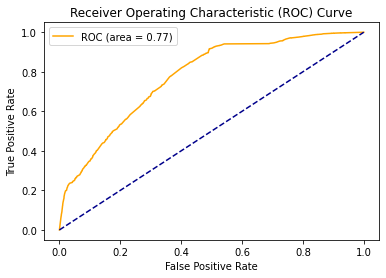

In [37]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_true=predictions_df['r_ui'], y_score=predictions_df['est'])
auc = metrics.roc_auc_score(y_true=predictions_df['r_ui'], y_score=predictions_df['est'])
print('AUC: %.9f' % auc)

import matplotlib.pyplot as plt
plt.plot(fpr, tpr, color='orange', label='ROC (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()
plt.savefig('aroc_v29v30.png')
plt.close()

In [2]:
data_interaction_v29 = pd.read_csv(filepath_or_buffer='predictions_df_29.csv', index_col=0)

In [3]:
data_interaction_v29

,uid,iid,r_ui,est,details
0,350494,754,1.0,0.646738,{'was_impossible': False}
1,363890,1430,1.0,0.012447,{'was_impossible': False}
2,363889,1430,1.0,0.012447,{'was_impossible': False}
3,363883,1430,1.0,0.012447,{'was_impossible': False}
4,363882,1430,1.0,0.012447,{'was_impossible': False}
...,...,...,...,...,...
72911,2536230,324,1.0,0.117374,{'was_impossible': False}
72912,2520968,324,1.0,0.117374,{'was_impossible': False}
72913,2516709,325,-1.0,0.105297,{'was_impossible': False}
72914,2521966,325,-1.0,0.105297,{'was_impossible': False}
